## 0.数据读取和处理

In [0]:
import os
import copy
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, utils
import matplotlib.pylab as plt

import torch.nn as nn
import torch.optim as optim

In [5]:
class DTSet(Dataset):
    
    def __init__(self, img_root, label_path, transform=None):
        self.img_root = img_root
        self.transform = transform
        self.labels = pd.read_excel(label_path, 
                                    true_values=["'High'", "'MIBC'"],
                                    false_values=["'Low'","'NMIBC'"])
        
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, idx):
        #img_path = self.img_root + "/" + self.labels.iloc[idx, 0].strip("'") + ".jpg"
        img_path = self.img_root + "/" + self.labels.iloc[idx, 0].strip("'")
        img = cv2.imread(img_path)
        img = Image.fromarray(img.astype('uint8')).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        grade = self.labels.iloc[idx, 1].astype(np.float)
        stage = self.labels.iloc[idx, 2].astype(np.float)
        
        sample = {'img':img, 'grade':grade, 'stage':stage}
        return sample


def show_sample(sample):
    """
        sample['img'].shape = (H, W, C)
    """
    title = "grade: " + str(sample['grade']) + " stage: " + str(sample['stage'])
    plt.figure()
    plt.imshow(sample['img'])
    plt.title(title)
    plt.axis('off')
    

def show_batch(batch):
    plt.figure()
    imgs = batch['img']
    print(imgs.shape)
    batch_size = len(imgs)
    grid = utils.make_grid(imgs)
    plt.imshow(grid.numpy().transpose(1,2,0))
    plt.axis('off')
    plt.show()


#dataset = DTSet('data/TrainingData', 'data/DataInfo.xlsx')
#show_sample(dataset[0])

dataset = DTSet('data/Train_img', 
                'data/Train_label.xlsx', 
                transforms.Compose([
                    transforms.RandomAffine(10, translate=(0.05, 0.05), fillcolor=0),
                    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                    transforms.Resize((512,512)),
                    transforms.ToTensor()
                ]))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 1.模型定义

In [0]:
class Net(nn.Module):
  
    def __init__(self):
        super().__init__()
        self.norm0 = nn.BatchNorm2d(3, eps=1e-08)
        
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(64, eps=1e-08)
        self.nonlinear1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(64, 64, 8, stride=3) # 169
        self.norm2 = nn.BatchNorm2d(64, eps=1e-08)
        self.nonlinear2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(64, 64, 5, stride=2) # 83
        self.norm3 = nn.BatchNorm2d(64, eps=1e-8)
        self.nonlinear3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(64, 64, 5, stride=2) # 40
        self.norm4 = nn.BatchNorm2d(64, eps=1e-8)
        self.nonlinear4 = nn.ReLU()
        
        self.conv5 = nn.Conv2d(64, 64, 5) # 36
        self.norm5 = nn.BatchNorm2d(64, eps=1e-8)
        self.nonlinear5 = nn.ReLU()
        
        self.conv6 = nn.Conv2d(64, 64, 5) # 32
        self.norm6 = nn.BatchNorm2d(64, eps=1e-8)
        self.nonlinear6 = nn.ReLU()
        
        self.conv7 = nn.Conv2d(64, 64, 32) # 64, 1, 1
        self.norm7 = nn.BatchNorm2d(64, eps=1e-8)
        self.nonlinear7 = nn.ReLU()
        
        self.fc1 = nn.Linear(64, 500)
        self.norm8 = nn.BatchNorm1d(500, eps=1e-8)
        self.nonlinear8 = nn.ReLU()
        
        self.fc2 = nn.Linear(500, 400)
        self.norm9 = nn.BatchNorm1d(400, eps=1e-8)
        self.nonlinear9 = nn.ReLU()
        
        self.fc3 = nn.Linear(400, 300)
        self.normX = nn.BatchNorm1d(300, eps=1e-8)
        self.nonlinearX = nn.ReLU()
        
        self.fc4 = nn.Linear(300, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        out = self.norm0(x)
        out = self.nonlinear1(self.norm1(self.conv1(out)))
        out = self.nonlinear2(self.norm2(self.conv2(out)))
        out = self.nonlinear3(self.norm3(self.conv3(out)))
        out = self.nonlinear4(self.norm4(self.conv4(out)))
        out = self.nonlinear5(self.norm5(self.conv5(out)))
        out = self.nonlinear6(self.norm6(self.conv6(out)))
        out = self.nonlinear7(self.norm7(self.conv7(out)))
        
        N = out.size(0)
        out = out.view(N, -1)
        
        out = self.nonlinear8(self.norm8(self.fc1(out)))
        out = self.nonlinear9(self.norm9(self.fc2(out)))
        out = self.nonlinearX(self.normX(self.fc3(out)))
        out = self.fc4(out).view(-1).double()
        return out

### 1.1.Sanity check

In [7]:
epochs = 20

shuffle_mask = np.arange(len(dataset))
np.random.shuffle(shuffle_mask)
trainset = Subset(dataset, shuffle_mask[:20])    
train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)

for target_type in ['grade', 'stage']:
    torch.cuda.empty_cache()
    model = Net()
    model.zero_grad()
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-8)
    criterion = nn.BCEWithLogitsLoss()
    
    print("Sanity check for ", target_type)
    for epoch in range(epochs):
        train_acc = 0.0
        train_loss = 0.0
        model.train()
        for samples in train_loader:
            imgs = samples['img'].to(device)
            gt = samples[target_type].to(device)
            optimizer.zero_grad()

            scores = model(imgs)
            scores = scores.view(-1).double()
            loss = criterion(scores, gt) #criterion
            loss.backward()
            optimizer.step()

            scores[scores>0] = 1
            scores[scores<=0] = 0

            train_acc += (scores==gt).sum().cpu().numpy()
            train_loss += loss.item()*imgs.size(0)
        train_acc /= len(trainset)
        train_loss /= len(trainset)

        print("epoch %d / %d: acc %.4f loss %.4f" 
              %(epoch, epochs-1, train_acc, train_loss))
    print()

Sanity check for  grade
epoch 0 / 19: acc 0.3500 loss 0.7275
epoch 1 / 19: acc 0.4500 loss 0.7051
epoch 2 / 19: acc 0.7000 loss 0.6139
epoch 3 / 19: acc 0.8000 loss 0.5050
epoch 4 / 19: acc 0.9500 loss 0.4183
epoch 5 / 19: acc 0.8500 loss 0.4698
epoch 6 / 19: acc 1.0000 loss 0.3046
epoch 7 / 19: acc 0.9500 loss 0.2639
epoch 8 / 19: acc 1.0000 loss 0.2144
epoch 9 / 19: acc 0.9500 loss 0.2369
epoch 10 / 19: acc 0.9000 loss 0.2748
epoch 11 / 19: acc 0.9000 loss 0.2793
epoch 12 / 19: acc 1.0000 loss 0.1868
epoch 13 / 19: acc 1.0000 loss 0.1263
epoch 14 / 19: acc 1.0000 loss 0.1652
epoch 15 / 19: acc 1.0000 loss 0.1305
epoch 16 / 19: acc 0.9500 loss 0.1439
epoch 17 / 19: acc 0.9500 loss 0.1607
epoch 18 / 19: acc 1.0000 loss 0.0989
epoch 19 / 19: acc 1.0000 loss 0.1060

Sanity check for  stage
epoch 0 / 19: acc 0.5500 loss 0.6935
epoch 1 / 19: acc 0.6000 loss 0.7042
epoch 2 / 19: acc 0.5000 loss 0.6212
epoch 3 / 19: acc 0.6500 loss 0.5645
epoch 4 / 19: acc 0.7500 loss 0.4880
epoch 5 / 19: ac

## 2.训练

In [0]:
criterion = nn.BCEWithLogitsLoss()

def train(model, optimizer, epochs, target_type, verbose=True):
    """
        outside variable: device, criterion, train_loader,
                          val_loader trainset, valset
    """
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
    best_model=copy.deepcopy(model.state_dict())
    best_train_acc, best_val_acc = 0, 0
    best_train_loss, best_val_loss  = np.inf, np.inf
    
    model.to(device) # device
    for epoch in range(epochs):
        train_acc = 0.0
        train_loss = 0.0
        model.train()
        for samples in train_loader:
            imgs = samples['img'].to(device)
            gt = samples[target_type].to(device)
            
            scores = model(imgs)
            scores = scores.view(-1).double()
            loss = criterion(scores, gt) #criterion
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            scores[scores>0] = 1
            scores[scores<=0] = 0

            train_acc += (scores==gt).sum().cpu().numpy()
            train_loss += loss.item()*imgs.size(0)
        train_acc /= len(trainset)
        train_loss /= len(trainset)
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        
        model.eval()
        val_acc, val_loss = 0.0, 0.0
        with torch.no_grad():
            for samples in val_loader:
                imgs = samples['img'].to(device)
                gt = samples[target_type].to(device)
                
                scores = model(imgs)
                scores = scores.view(-1).double()
                loss = criterion(scores, gt)
                scores[scores>0] = 1
                scores[scores<=0] = 0
                
                val_acc += (scores == gt).sum().cpu().numpy()
                val_loss += loss.item()*imgs.size(0)
        
            val_acc /= len(valset)
            val_loss /= len(valset)
            history['val_acc'].append(val_acc)
            history['val_loss'].append(val_loss)
            
        if val_acc >= best_val_acc and val_loss < best_val_loss:
            best_train_acc = train_acc
            best_val_acc = val_acc
            best_train_loss, best_val_loss = train_loss, val_loss
            best_model = copy.deepcopy(model.state_dict())
        
        if verbose:
            print("Epoch %d / %d train_loss %.4f train_acc %.4f val_loss %.4f val_acc %.4f"
                 %(epoch, epochs-1, train_loss, train_acc, val_loss, val_acc))
    if verbose:
        plt.figure()
        plt.plot(history['train_loss'])
        plt.plot(history['val_loss'])
        plt.title('training loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['training', 'validation'], loc='upper left')
        
        plt.figure()
        plt.plot(history['train_acc'])
        plt.plot(history['val_acc'])
        plt.title('training accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(['training', 'validation'], loc='upper left')
        plt.show()
    
    print("best training acc %.4f best training loss %.4f best val acc %.4f best val loss %.4f"
         %(best_train_acc, best_train_loss, best_val_acc, best_val_loss))
    model.load_state_dict(best_model)
    return model
  

def predict(model, target_type):
    acc, loss = 0.0, 0.0
    loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)
    model.eval()
    with torch.no_grad():
        for samples in loader:
            imgs = samples['img'].to(device)
            gt = samples[target_type].to(device)
                
            scores = model(imgs)
            scores = scores.view(-1).double()
            loss = criterion(scores, gt)
            scores[scores>0] = 1
            scores[scores<=0] = 0
               
            acc += (scores == gt).sum().cpu().numpy()
            loss += loss.item()*imgs.size(0)
            
        acc = acc/len(dataset)
        loss /= len(dataset)
        print("total accuracy %.4f total loss %.4f" % (acc, loss))
        
        if acc>0.9:
            fname = target_type+'_acc_'+str(acc)+'_loss_'+str(float(loss))+'.pth'
            torch.save(model.state_dict(), fname)

### 2.1.Grade预测模型训练

Epoch 0 / 49 train_loss 0.6284 train_acc 0.6319 val_loss 0.6942 val_acc 0.4769
Epoch 1 / 49 train_loss 0.4682 train_acc 0.7838 val_loss 0.3047 val_acc 0.8615
Epoch 2 / 49 train_loss 0.3087 train_acc 0.8764 val_loss 0.3546 val_acc 0.8769
Epoch 3 / 49 train_loss 0.2212 train_acc 0.9163 val_loss 0.2762 val_acc 0.8615
Epoch 4 / 49 train_loss 0.1868 train_acc 0.9331 val_loss 0.1282 val_acc 0.9692
Epoch 5 / 49 train_loss 0.1793 train_acc 0.9356 val_loss 0.0763 val_acc 0.9846
Epoch 6 / 49 train_loss 0.1708 train_acc 0.9318 val_loss 0.3103 val_acc 0.8462
Epoch 7 / 49 train_loss 0.1619 train_acc 0.9447 val_loss 0.2829 val_acc 0.8462
Epoch 8 / 49 train_loss 0.1372 train_acc 0.9562 val_loss 0.2536 val_acc 0.9077
Epoch 9 / 49 train_loss 0.0963 train_acc 0.9743 val_loss 0.0462 val_acc 1.0000
Epoch 10 / 49 train_loss 0.0999 train_acc 0.9653 val_loss 0.1132 val_acc 0.9538
Epoch 11 / 49 train_loss 0.1051 train_acc 0.9653 val_loss 0.2130 val_acc 0.8923
Epoch 12 / 49 train_loss 0.0630 train_acc 0.9833 v

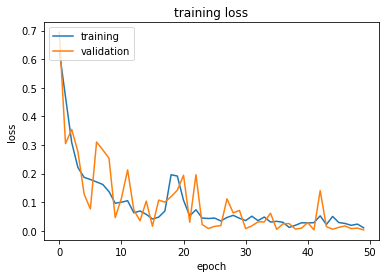

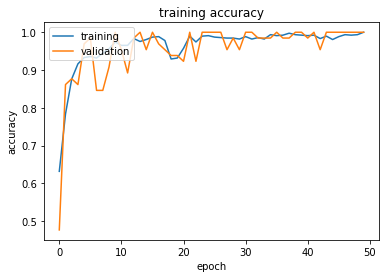

best training acc 1.0000 best training loss 0.0105 best val acc 1.0000 best val loss 0.0030
total accuracy 1.0000 total loss 0.0000


In [9]:
torch.cuda.empty_cache()
target_type = 'grade'

grade_predictor = Net()
grade_predictor.zero_grad()

optimizer = optim.Adam(grade_predictor.parameters(), lr=0.0005, eps=1e-8)

shuffle_mask = np.arange(len(dataset))
np.random.shuffle(shuffle_mask)
trainset = Subset(dataset, shuffle_mask[:731])
valset = Subset(dataset, shuffle_mask[731:])

train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=4)

grade_predictor = train(grade_predictor, optimizer, 50, target_type, verbose=True)

predict(grade_predictor, 'grade')

### 2.2.Stage预测模型（迁移）训练

Epoch 0 / 29 train_loss 2.3387 train_acc 0.6484 val_loss 1.4525 val_acc 0.6847
Epoch 1 / 29 train_loss 1.0639 train_acc 0.7237 val_loss 0.5281 val_acc 0.7838
Epoch 2 / 29 train_loss 0.5423 train_acc 0.8290 val_loss 0.3403 val_acc 0.8378
Epoch 3 / 29 train_loss 0.3195 train_acc 0.8933 val_loss 0.2175 val_acc 0.9099
Epoch 4 / 29 train_loss 0.1903 train_acc 0.9234 val_loss 0.1147 val_acc 0.9640
Epoch 5 / 29 train_loss 0.1528 train_acc 0.9508 val_loss 0.1271 val_acc 0.9459
Epoch 6 / 29 train_loss 0.1322 train_acc 0.9603 val_loss 0.1965 val_acc 0.9550
Epoch 7 / 29 train_loss 0.0882 train_acc 0.9658 val_loss 0.0861 val_acc 0.9730
Epoch 8 / 29 train_loss 0.0621 train_acc 0.9767 val_loss 0.0405 val_acc 0.9910
Epoch 9 / 29 train_loss 0.0915 train_acc 0.9754 val_loss 0.0680 val_acc 0.9820
Epoch 10 / 29 train_loss 0.0454 train_acc 0.9850 val_loss 0.0225 val_acc 0.9910
Epoch 11 / 29 train_loss 0.0687 train_acc 0.9795 val_loss 0.0277 val_acc 0.9910
Epoch 12 / 29 train_loss 0.0409 train_acc 0.9863 v

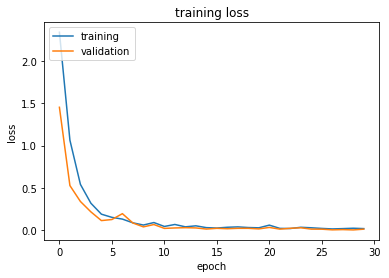

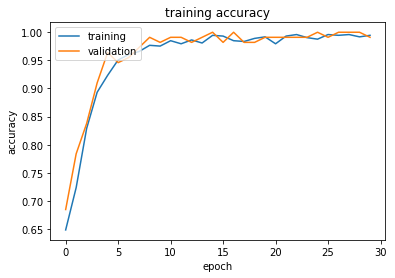

best training acc 0.9918 best training loss 0.0243 best val acc 1.0000 best val loss 0.0045
total accuracy 0.9988 total loss 0.0000


In [10]:
target_type = 'stage'
torch.cuda.empty_cache()

stage_predictor = Net()
if grade_predictor is not None:
    stage_predictor.load_state_dict(grade_predictor.state_dict()) # transfer

optimizer = optim.Adam(stage_predictor.parameters(), lr=0.0001, eps=1e-8)

shuffle_mask = np.arange(len(dataset))
np.random.shuffle(shuffle_mask)
trainset = Subset(dataset, shuffle_mask[:731])
valset = Subset(dataset, shuffle_mask[731:])    
train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=4)

stage_predictor = train(stage_predictor, optimizer, 30, 'stage', verbose=True)

predict(stage_predictor, target_type)

### 2.3.Stage预测模型（非迁移）训练

Epoch 0 / 29 train_loss 0.6611 train_acc 0.6115 val_loss 0.6932 val_acc 0.4955
Epoch 1 / 29 train_loss 0.5474 train_acc 0.7674 val_loss 0.5703 val_acc 0.7387
Epoch 2 / 29 train_loss 0.3933 train_acc 0.8851 val_loss 0.3403 val_acc 0.9459
Epoch 3 / 29 train_loss 0.2931 train_acc 0.9124 val_loss 0.3014 val_acc 0.9459
Epoch 4 / 29 train_loss 0.2447 train_acc 0.9302 val_loss 0.1837 val_acc 0.9730
Epoch 5 / 29 train_loss 0.1996 train_acc 0.9576 val_loss 0.1472 val_acc 0.9820
Epoch 6 / 29 train_loss 0.1603 train_acc 0.9699 val_loss 0.1382 val_acc 0.9820
Epoch 7 / 29 train_loss 0.1401 train_acc 0.9713 val_loss 0.2106 val_acc 0.9640
Epoch 8 / 29 train_loss 0.1616 train_acc 0.9576 val_loss 0.1105 val_acc 0.9820
Epoch 9 / 29 train_loss 0.1188 train_acc 0.9767 val_loss 0.1088 val_acc 0.9730
Epoch 10 / 29 train_loss 0.1142 train_acc 0.9713 val_loss 0.1395 val_acc 0.9550
Epoch 11 / 29 train_loss 0.0969 train_acc 0.9808 val_loss 0.1220 val_acc 0.9820
Epoch 12 / 29 train_loss 0.0833 train_acc 0.9863 v

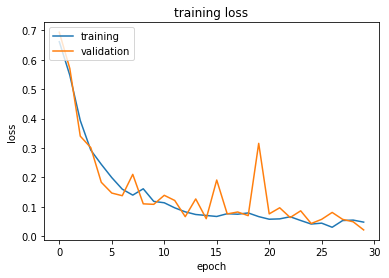

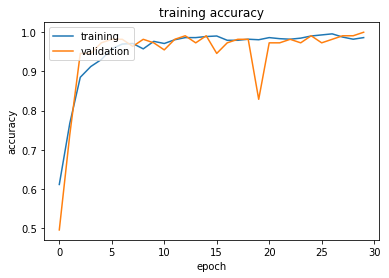

best training acc 0.9863 best training loss 0.0484 best val acc 1.0000 best val loss 0.0220
total accuracy 0.9988 total loss 0.0016


In [11]:
target_type = 'stage'
torch.cuda.empty_cache()

stage_predictor = Net()

optimizer = optim.Adam(stage_predictor.parameters(), lr=0.0001, eps=1e-8)

stage_predictor = train(stage_predictor, optimizer, 30, 'stage', verbose=True)

predict(stage_predictor, target_type)